In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.signal import welch

Cargamos los datos

In [11]:
eeg1 = pd.read_csv("participantes/eeg_pp_4.csv")

features1 = pd.read_csv("participantes/eeg_features_4.csv")

In [12]:
features1.head()

,epoch,window,n_samples,Start_w,End_w,Trust,Binary_Trust,ch1-Delta-DE,ch1-Delta-PSD,ch1-Delta-Mean,...,ch19-LowGamma-PSD,ch19-LowGamma-Mean,ch19-LowGamma-Std,ch19-LowGamma-PeakToPeak,ch19-LowGamma-Skew,ch19-LowGamma-Kurt,ch19-LowGamma-RelPow,ch19-LowGamma-HjAct,ch19-LowGamma-HjMob,ch19-LowGamma-HjComp
0,1,1,37,0.000000,0.144531,NaN,NaN,2.213065,4.895186,-8.732949,...,23.092345,0.433583,5.996138,23.822273,0.167336,-0.535362,0.260997,35.953676,0.949115,1.095933
1,1,2,37,0.070312,0.214844,NaN,NaN,2.108361,3.970310,-3.320073,...,17.290485,0.520221,4.773889,21.699036,0.724706,0.609719,0.202073,22.790020,0.964883,1.126381
2,1,3,37,0.140625,0.285156,NaN,NaN,-0.916157,0.009370,0.026719,...,4.455634,0.057951,1.942388,8.137000,0.002214,-0.352237,0.391898,3.772872,1.125717,1.056430
3,1,4,37,0.210938,0.355469,NaN,NaN,1.638954,1.552755,-4.762926,...,7.304491,0.126536,2.235138,10.177430,-0.143656,-0.091336,0.117334,4.995844,1.018800,1.060124
4,1,5,37,0.281250,0.425781,NaN,NaN,2.215783,4.921869,-8.445210,...,1.431226,-0.058250,1.954970,10.173725,-0.028499,1.282286,0.114403,3.821908,1.045144,1.070171


In [5]:
len(eeg1), len(features1)

(97280, 2320)

In [6]:
features1.isnull().sum()

epoch                   0
window                  0
n_samples               0
Start_w                 0
End_w                   0
                       ..
ch19-LowGamma-Kurt      0
ch19-LowGamma-RelPow    0
ch19-LowGamma-HjAct     0
ch19-LowGamma-HjMob     0
ch19-LowGamma-HjComp    0
Length: 1261, dtype: int64

In [8]:
features1['Trust'].value_counts(dropna=False)

Trust
1.0    1000
3.0     550
NaN     320
2.0     300
4.0     150
Name: count, dtype: int64

In [13]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [14]:
def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_5188\2393793452.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'high_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 29382 de un total de 97280

Distribución Binary_Trust:
Binary_Trust
high_trust    35069
low_trust     32829
NaN           29382
Name: count, dtype: int64

Distribución Trust:
Trust
1.0    32829
NaN    29382
3.0    18003
2.0    12703
4.0     4363
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [15]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 67898

Distribución Binary_Trust:
Binary_Trust
high_trust    35069
low_trust     32829
Name: count, dtype: int64

Distribución Trust:
Trust
1.0    32829
3.0    18003
2.0    12703
4.0     4363
Name: count, dtype: int64


C:\Users\crist\AppData\Local\Temp\ipykernel_5188\4256698990.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


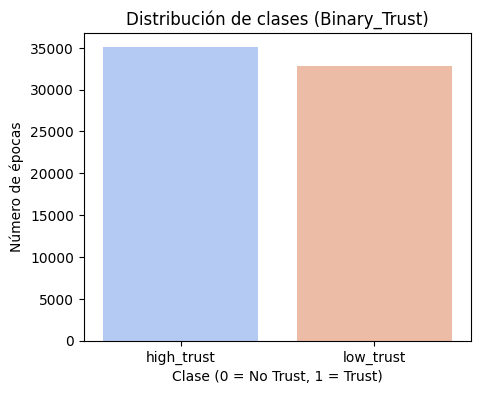

Distribución porcentual:
 Binary_Trust
high_trust    0.516495
low_trust     0.483505
Name: proportion, dtype: float64


In [16]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

## Red Neuronal EEGNet

In [17]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from skorch.helper import predefined_split

In [18]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 256.4225713761181


### Trial Wise

Dividimos los datos de manera que no queden muestras mezcladas en los distintos conjuntos de entrenamiento, validación y test

In [21]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación (estratificado para mantener proporción)
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list = [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor

X_train_t, y_train_t = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t  = make_trial_windows(df_test,  window_size=256, stride=32)

print(X_train_t.shape, y_train_t.shape)




torch.Size([537, 19, 256]) torch.Size([537])


### Selección de características

In [20]:
# === 2. Selección de canales (ANOVA) ===
from sklearn.feature_selection import f_classif

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 (significativos)
k = 10  
selected_channels = np.argsort(F_values)[-k:]  
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados: [18  9  7 13  8  5 11 10  3  4]
Nueva forma de X_train: torch.Size([537, 10, 256])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:]  # Top 10 canales

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [14 17 12  9 10  3  5  4 13  1]
Nueva forma de X_train: torch.Size([537, 10, 256])


In [150]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)

Canales finales (híbrido): [18 15  7 14 17 12 10  5 13  1]


#### Normalización de los datos

In [22]:
mean = X_train_t.mean(dim=(0,2), keepdim=True)  
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


In [19]:
print(X_train_t.shape) 

torch.Size([537, 19, 256])


In [287]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [288]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 284
Valid windows: 83
Test windows: 113


### Modelo y entrenamiento

#### Creación del modelo

In [ ]:
chans = 19       
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
    F1=8,F2=16,
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

#### Entrenamiento del modelo

In [ ]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False, name='f1_macro')

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    # callbacks=f1_macro,
            #    early_stopping],
    max_epochs=30,
    device='cpu',
)


In [32]:
clf.fit(X_train_t, y_train_t)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7284       0.5590        0.6879  1.1290
      2        0.7008       0.5776        0.6869  0.9617
      3        0.6833       0.5714        0.6862  0.5393
      4        0.6850       0.5901        0.6853  0.5585
      5        0.6488       0.6025        0.6851  0.5212
      6        0.6350       0.6087        0.6848  0.4725
      7        0.6309       0.5901        0.6845  0.4856
      8        0.6009       0.5714        0.6835  0.6677
      9        0.5910       0.5714        0.6837  0.5819
     10        0.5719       0.5714        0.6853  0.5114
     11        0.5509       0.5901        0.6844  0.4871
     12        0.5610       0.6087        0.6823  0.4891
     13        0.5548       0.6211        0.6823  0.4849
     14        0.5178       0.6273        0.6796  0.4890
     15        0.5068       0.6273        0.6808  0.4880
     16        0.4908       0.6

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 19, 256]              [1, 19, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 19, 256]           [1, 8, 19, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 19, 257]           [1, 8, 19, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 19, 257]           [1, 16, 1, 257]           --                        [19, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 19, 1]            304                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

#### Test

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[102   3]
 [ 87  22]]
              precision    recall  f1-score   support

           0       0.54      0.97      0.69       105
           1       0.88      0.20      0.33       109

    accuracy                           0.58       214
   macro avg       0.71      0.59      0.51       214
weighted avg       0.71      0.58      0.51       214



In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.636


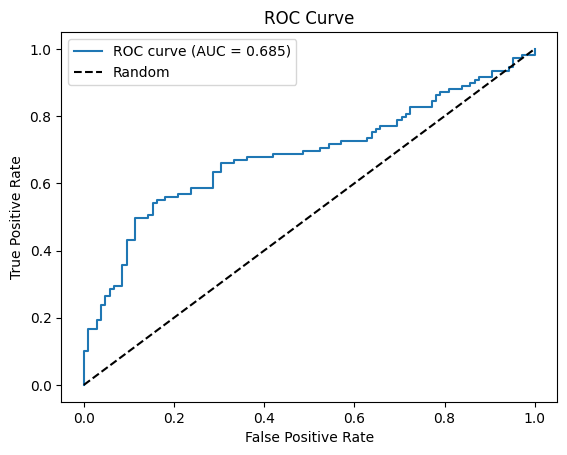

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## RED EEGNeX

In [23]:
from braindecode.models import EEGNeX

In [24]:
chans = 19      
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
)

In [25]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [26]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False, name='f1_macro')

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=12,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro, 
               early_stopping],
    max_epochs=30,
    device='cpu',
)


In [27]:
clf.fit(X_train_t, y_train_t)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv2d(


  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3855        0.6728       0.6273        0.6760  7.4358
      2      0.3482        0.6105       0.5342        0.7045  7.4984
      3      0.3684        0.5756       0.5528        0.6867  17.0851
      4      0.3272        0.5094       0.4472        0.7776  19.1096
      5      0.4569        0.4533       0.5093        0.7530  16.2054
      6      0.5619        0.4113       0.5839        0.8842  11.3805
      7      0.5000        0.3745       0.5093        0.8670  7.0298
      8      0.5071        0.3502       0.5155        0.9843  6.8896
      9      0.4890        0.2939       0.4969        1.0448  6.3971
     10      0.5453        0.2742       0.5590        0.9866  6.4956
     11      0.5417        0.2628       0.5528        0.7909  9.0986
     12      0.5008        0.2381       0.5031        1.0102  11.7907
     13      0.4633        0.

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 19, 256]              [1, 8, 19, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 19, 256]              [1, 1, 19, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 19, 256]           [1, 8, 19, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 19, 256]           [1, 8, 19, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 19, 256]           [1, 32, 19, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 19, 256]           [1, 32, 19, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 19, 256]          [1, 32, 19, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 19, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 19, 256]          [1, 64, 1, 256]           --                        [19, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        1,216                     --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [28]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[78 27]
 [34 75]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       105
           1       0.74      0.69      0.71       109

    accuracy                           0.71       214
   macro avg       0.72      0.72      0.71       214
weighted avg       0.72      0.71      0.71       214



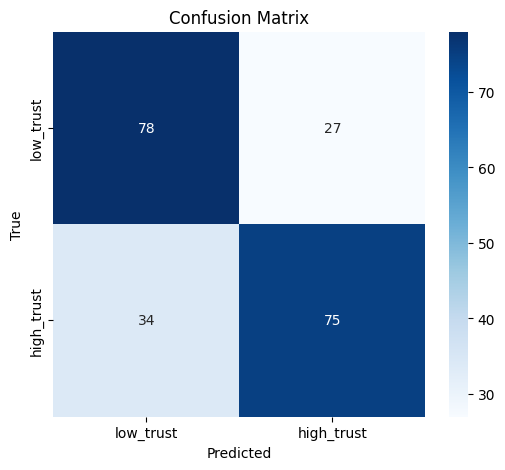

In [29]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.722


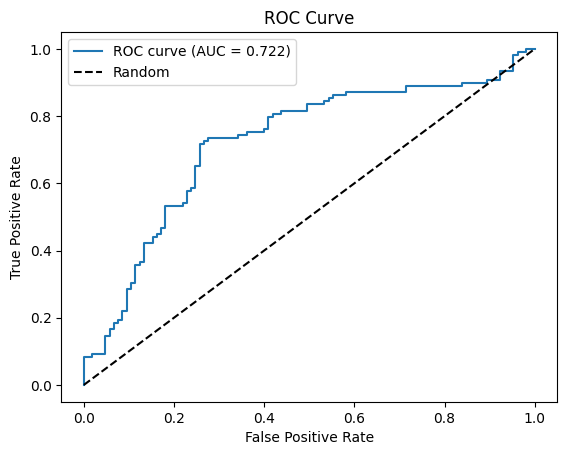

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## AttentionBaseNet

In [174]:
from braindecode.models import AttentionBaseNet


In [176]:
model = AttentionBaseNet(
    n_chans=19,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.2,
    drop_prob_attn= 0.5,

)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights_tensor = torch.tensor([0.6, 0.4], dtype=torch.float32)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from skorch.callbacks import EarlyStopping, EpochScoring, LRScheduler

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)


valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=5e-3,
    optimizer__lr=1e-4,
    batch_size=64,
    # callbacks=[early_stopping],
    max_epochs=40,
    device='cpu',
)


In [179]:
clf.fit(
    X_train_t, 
    y_train_t, 
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7043       0.3727        0.7071  4.8140
      2        0.6876       0.3913        0.7112  2.1352
      3        0.6922       0.4410        0.7246  2.0194
      4        0.6846       0.4410        0.7450  1.7604
      5        0.6867       0.4099        0.7633  1.8896
      6        0.6860       0.4286        0.7733  3.0090
      7        0.6743       0.4286        0.7772  2.3939
      8        0.6686       0.4224        0.7767  2.0193
      9        0.6686       0.4037        0.7782  2.1428
     10        0.6755       0.3851        0.7766  2.3366
     11        0.6571       0.3665        0.7750  2.4173
     12        0.6575       0.3727        0.7726  2.0636
     13        0.6670       0.3540        0.7711  2.1235
     14        0.6608       0.3416        0.7723  2.0801
     15        0.6509       0.3292        0.7722  3.7868
     16        0.6388       0.3

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 19, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 19, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 19, 256]              [1, 19, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 19, 256]           [1, 40, 19, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 19, 256]          [1, 40, 19, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 19, 256]          [1, 40, 1, 256]           760                       [19, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[71 34]
 [36 73]]
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       105
           1       0.68      0.67      0.68       109

    accuracy                           0.67       214
   macro avg       0.67      0.67      0.67       214
weighted avg       0.67      0.67      0.67       214



In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()
roc_auc = roc_auc_score(y_true, y_proba)

print(f"ROC-AUC: {roc_auc:.3f}")

ROC-AUC: 0.753
